<a href="https://colab.research.google.com/github/KolipakaRamesh/AIML_Practice_Excercises/blob/main/Transformer_Py_Step_By_Step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Understanding the Transformer Code - Step by Step

Let's break down the code into smaller, more manageable parts with detailed explanations.

### 1. Imports

This section imports the necessary libraries from PyTorch and Matplotlib.

*   `torch`: The main PyTorch library for building neural networks.
*   `torch.nn`: Contains modules and classes for building neural network layers.
*   `torch.nn.functional`: Provides functions for neural network operations (like softmax).
*   `math`: Used for mathematical operations, specifically for the positional encoding.
*   `matplotlib.pyplot`: Used for plotting graphs, like the training loss.
*   `torch.optim`: Contains optimization algorithms, like Adam, used for training.

In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import torch.optim as optim

### 2. Positional Encoding

The `PositionalEncoding` class adds information about the position of each token in the sequence. Transformers process sequences in parallel, so they don't inherently know the order of tokens. Positional encoding provides this crucial information.

The encoding is done using sine and cosine functions of different frequencies.

In [51]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        # Create a matrix of shape (max_len, d_model) to store the positional encodings
        pe = torch.zeros(max_len, d_model)

        # Create a tensor of positions (0, 1, 2, ...)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Calculate the division term for the sine and cosine arguments
        # This creates frequencies that decrease exponentially
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sine to even indices in the positional encoding matrix
        pe[:, 0::2] = torch.sin(position * div_term)

        # Apply cosine to odd indices in the positional encoding matrix
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add an extra dimension for the batch size (even though we only have one encoding matrix)
        pe = pe.unsqueeze(0)

        # Register the positional encoding matrix as a buffer.
        # Buffers are tensors that are part of the module's state but not its parameters (they are not updated by gradients).
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add the positional encoding to the input tensor x
        # We slice the positional encoding to match the sequence length of the input tensor
        x = x + self.pe[:, :x.size(1)]
        return x

### 3. Scaled Dot-Product Attention

This is the fundamental attention mechanism used in the Transformer. It calculates the attention between a query and a set of keys and values.

The process involves:
1.  Calculating the dot product of the Query and Key tensors.
2.  Scaling the dot product by the square root of the dimension of the keys (`d_k`) to prevent large values from dominating the softmax.
3.  Optionally applying a mask to ignore certain positions (e.g., padding tokens or future tokens in the decoder).
4.  Applying a softmax function to get attention weights, which represent how much attention each position in the query attends to each position in the key.
5.  Multiplying the attention weights by the Value tensor to get the output.

In [52]:
def scaled_dot_product_attention(query, key, value, mask=None):
    """
    Calculates scaled dot-product attention.

    Args:
        query (torch.Tensor): Query tensor of shape (batch_size, num_heads, seq_len, d_k).
        key (torch.Tensor): Key tensor of shape (batch_size, num_heads, seq_len, d_k).
        value (torch.Tensor): Value tensor of shape (batch_size, num_heads, seq_len, d_v).
        mask (torch.Tensor, optional): Mask tensor to prevent attention to certain positions.

    Returns:
        tuple: A tuple containing:
            - torch.Tensor: Output tensor after attention.
            - torch.Tensor: Attention weights.
    """
    d_k = query.size(-1)
    scaled_dot_product = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)

    if mask is not None:
        scaled_dot_product = scaled_dot_product.masked_fill(mask == 0, float('-inf'))

    attention_weights = F.softmax(scaled_dot_product, dim=-1)
    output = torch.matmul(attention_weights, value)

    return output, attention_weights

### 4. Multi-Head Attention

Multi-Head Attention allows the model to jointly attend to information from different representation subspaces at different positions. It does this by:

1.  Linearly projecting the Query, Key, and Value tensors multiple times with different learned linear projections. These projections are split into a specified number of "heads."
2.  Performing scaled dot-product attention in parallel for each of these heads.
3.  Concatenating the output of each attention head.
4.  Applying a final linear projection to the concatenated output.

In [53]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0 # Ensure the model dimension is divisible by the number of heads
        self.num_heads = num_heads
        self.d_k = d_model // num_heads # Dimension of each attention head

        # Linear layers for projecting Query, Key, Value, and the final output
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # Apply linear projections and reshape for multi-head attention
        # The view operation changes the tensor shape, and transpose rearranges the dimensions
        q = self.W_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        k = self.W_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        v = self.W_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Perform scaled dot-product attention for each head
        attention_output, _ = scaled_dot_product_attention(q, k, v, mask=mask)

        # Reshape and apply final linear projection
        # contiguous() is needed before view() if the tensor's memory layout is not contiguous
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        output = self.W_o(attention_output)

        return output

### 5. Feedforward and Layer Normalization

These components are applied after the attention mechanisms within each encoder and decoder layer.

*   **Feedforward Network**: This is a simple neural network with two linear layers and an activation function. It's applied independently to each position in the sequence and helps the model process the information learned by the attention layers.
*   **Layer Normalization**: This technique helps stabilize the training of deep networks by normalizing the activations of each layer across the features. It's typically applied before or after the attention and feedforward sub-layers.

In [54]:
class FeedForward(nn.Module):
    """
    A simple feedforward network with two linear layers and ReLU activation,
    followed by Layer Normalization.
    """
    def __init__(self, d_model, d_ff):
        """
        Args:
            d_model (int): The dimension of the input and output.
            d_ff (int): The dimension of the hidden layer.
        """
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after passing through the feedforward network.
        """
        return self.linear2(self.relu(self.linear1(x)))

class LayerNorm(nn.Module):
    """
    Layer Normalization module.
    """
    def __init__(self, features, eps=1e-6):
        """
        Args:
            features (int): The number of features to normalize.
            eps (float): A small value added to the variance to avoid division by zero.
        """
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying layer normalization.
        """
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

### 6. Encoder Layer Implementation

This class represents a single layer of the Transformer encoder. The encoder's role is to process the input sequence and create a representation of it.

Each encoder layer consists of two main sub-layers:
1.  **Multi-Head Self-Attention**: This allows the encoder to weigh the importance of different words in the input sequence relative to each other.
2.  **Feedforward Network**: A simple neural network applied to each position independently.

Both sub-layers are followed by a residual connection and Layer Normalization.

In [55]:
class EncoderLayer(nn.Module):
    """
    A single encoder layer in a Transformer model.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout):
        """
        Args:
            d_model (int): The dimension of the input and output.
            num_heads (int): The number of attention heads.
            d_ff (int): The dimension of the hidden layer in the feedforward network.
            dropout (float): The dropout rate.
        """
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = LayerNorm(d_model)
        self.norm2 = LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        """
        Args:
            x (torch.Tensor): Input tensor to the encoder layer.
            mask (torch.Tensor, optional): Mask tensor for self-attention.

        Returns:
            torch.Tensor: Output tensor from the encoder layer.
        """
        # LayerNorm before self-attention
        normalized_x = self.norm1(x)
        # Self-attention with residual connection and dropout
        attn_output = self.self_attn(normalized_x, normalized_x, normalized_x, mask)
        x = x + self.dropout(attn_output)

        # LayerNorm before feedforward
        normalized_x = self.norm2(x)
        # Feedforward with residual connection and dropout
        ff_output = self.feed_forward(normalized_x)
        x = x + self.dropout(ff_output)

        return x

### 7. Decoder Layer Implementation

This class represents a single layer of the Transformer decoder. The decoder's role is to generate the output sequence based on the encoder's output and the previously generated tokens.

Each decoder layer consists of three main sub-layers:
1.  **Masked Multi-Head Self-Attention**: Similar to the encoder's self-attention, but masked to prevent attending to future tokens in the output sequence during training (to simulate the sequential generation process).
2.  **Multi-Head Encoder-Decoder Attention**: This attention mechanism allows the decoder to attend to the output of the encoder, focusing on the most relevant parts of the input sequence for generating the current output token.
3.  **Feedforward Network**: A simple neural network applied to each position independently.

All sub-layers are followed by a residual connection and Layer Normalization.

In [56]:
class DecoderLayer(nn.Module):
    """
    A single decoder layer in a Transformer model.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout):
        """
        Args:
            d_model (int): The dimension of the input and output.
            num_heads (int): The number of attention heads.
            d_ff (int): The dimension of the hidden layer in the feedforward network.
            dropout (float): The dropout rate.
        """
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.encoder_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = LayerNorm(d_model)
        self.norm2 = LayerNorm(d_model)
        self.norm3 = LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        """
        Args:
            x (torch.Tensor): Input tensor to the decoder layer (target sequence).
            encoder_output (torch.Tensor): Output tensor from the encoder.
            src_mask (torch.Tensor, optional): Mask tensor for encoder-decoder attention.
            tgt_mask (torch.Tensor, optional): Mask tensor for masked self-attention in the decoder.

        Returns:
            torch.Tensor: Output tensor from the decoder layer.
        """
        # Masked self-attention
        normalized_x = self.norm1(x)
        self_attn_output = self.self_attn(normalized_x, normalized_x, normalized_x, mask=tgt_mask)
        x = x + self.dropout(self_attn_output)

        # Encoder-decoder attention
        normalized_x = self.norm2(x)
        encoder_attn_output = self.encoder_attn(normalized_x, encoder_output, encoder_output, mask=src_mask)
        x = x + self.dropout(encoder_attn_output)

        # Feedforward
        normalized_x = self.norm3(x)
        ff_output = self.feed_forward(normalized_x)
        x = x + self.dropout(ff_output)

        return x

### 8. Transformer Model Implementation

This class puts together the Encoder and Decoder layers to form the complete Transformer architecture. It includes:

*   **Embedding Layers**: To convert input and target tokens into numerical representations (vectors).
*   **Positional Encoding**: Added to the embeddings to incorporate sequence order information.
*   **Encoder Stack**: Multiple Encoder layers stacked on top of each other to process the input sequence.
*   **Decoder Stack**: Multiple Decoder layers stacked on top of each other to generate the output sequence.
*   **Final Linear Layer**: To project the decoder's output to the size of the target vocabulary, giving probabilities for each possible next token.

In [57]:
class Transformer(nn.Module):
    """
    A complete Transformer model architecture.
    """
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_encoder_layers, num_decoder_layers, d_ff, dropout):
        """
        Args:
            src_vocab_size (int): The size of the source vocabulary.
            tgt_vocab_size (int): The size of the target vocabulary.
            d_model (int): The dimension of the model's embeddings.
            num_heads (int): The number of attention heads.
            num_encoder_layers (int): The number of encoder layers.
            num_decoder_layers (int): The number of decoder layers.
            d_ff (int): The dimension of the hidden layer in the feedforward networks.
            dropout (float): The dropout rate.
        """
        super(Transformer, self).__init__()
        self.d_model = d_model

        # Embedding layers
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)

        # Positional Encoding
        self.positional_encoding = PositionalEncoding(d_model)

        # Encoder stack
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_encoder_layers)])

        # Decoder stack
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_decoder_layers)])

        # Final linear layer
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

        self.dropout = nn.Dropout(dropout)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        """
        Args:
            src (torch.Tensor): Source sequence tensor.
            tgt (torch.Tensor): Target sequence tensor.
            src_mask (torch.Tensor, optional): Mask for the source sequence.
            tgt_mask (torch.Tensor, optional): Mask for the target sequence.

        Returns:
            torch.Tensor: Output tensor representing the predicted target sequence.
        """
        # Apply embeddings and positional encoding
        src_embedded = self.dropout(self.positional_encoding(self.src_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.tgt_embedding(tgt)))

        # Pass through encoder stack
        encoder_output = src_embedded
        for encoder_layer in self.encoder_layers:
            encoder_output = encoder_layer(encoder_output, src_mask)

        # Pass through decoder stack
        decoder_output = tgt_embedded
        for decoder_layer in self.decoder_layers:
            decoder_output = decoder_layer(decoder_output, encoder_output, src_mask, tgt_mask)

        # Apply final linear layer
        output = self.fc_out(decoder_output)

        return output

### 9. Tokenizer and Dummy Data

This section sets up a simple vocabulary and creates dummy input and target sequences to demonstrate how the model works.

*   **Vocabulary**: A list of all possible words the model can understand.
*   **Token Mapping**: Dictionaries to convert words to numbers (indices) and vice versa.
*   **Tokenizer Function**: A simple function to split text into words and convert them to their corresponding indices.
*   **Dummy Data**: Example source and target sequences converted into tensors that the model can process.

In [58]:
# Define a simple vocabulary and token mapping
vocab = ['<PAD>', '<SOS>', 'hello', 'world', 'transformer', 'model', 'pytorch', 'sequence', 'encoding', 'attention', 'feedforward', 'layer', 'normalization', 'encoder', 'decoder']

# Create token to index and index to token mappings
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for idx, word in enumerate(vocab)}

# Simple tokenizer function
def tokenize(text, word_to_idx):
    return [word_to_idx.get(word, word_to_idx['<PAD>']) for word in text.split()]

# Generate dummy data
dummy_src_text = "hello transformer model"
dummy_tgt_text = "hello pytorch sequence"

dummy_src_tokens = tokenize(dummy_src_text, word_to_idx)
dummy_tgt_tokens = tokenize(dummy_tgt_text, word_to_idx)

dummy_src_tensor = torch.LongTensor(dummy_src_tokens).unsqueeze(0) # Add batch dimension
dummy_tgt_tensor = torch.LongTensor(dummy_tgt_tokens).unsqueeze(0) # Add batch dimension

print("Source Text:", dummy_src_text)
print("Source Tokens:", dummy_src_tokens)
print("Source Tensor:", dummy_src_tensor)
print("\nTarget Text:", dummy_tgt_text)
print("Target Tokens:", dummy_tgt_tokens)
print("Target Tensor:", dummy_tgt_tensor)

Source Text: hello transformer model
Source Tokens: [2, 4, 5]
Source Tensor: tensor([[2, 4, 5]])

Target Text: hello pytorch sequence
Target Tokens: [2, 6, 7]
Target Tensor: tensor([[2, 6, 7]])


### 10. Training Loop with Dummy Data and Visualization

This section sets up a basic training process using the dummy data and visualizes the training loss.

*   **Model Instantiation**: Creates an instance of the Transformer model with specified parameters.
*   **Optimizer**: Defines the optimization algorithm (Adam) used to update model weights during training.
*   **Loss Function**: Defines the criterion (Cross-Entropy Loss) used to measure the difference between the model's output and the target sequence.
*   **Training Loop**: Iterates through a set number of epochs, performs forward and backward passes, and updates model weights to minimize the loss.
*   **Loss Tracking and Plotting**: Records the loss value at the end of each epoch and uses Matplotlib to plot how the loss changes over time.

Epoch [1/10], Loss: 3.4162
Epoch [2/10], Loss: 16.2449
Epoch [3/10], Loss: 51.9910
Epoch [4/10], Loss: 44.1209
Epoch [5/10], Loss: 16.1783
Epoch [6/10], Loss: 0.5032
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000

Training loop finished.


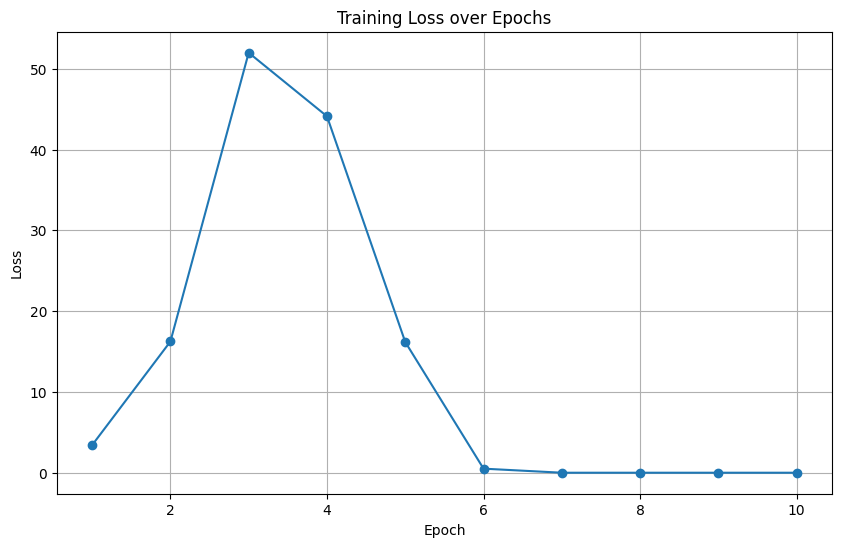

In [59]:
# Model parameters (example values)
src_vocab_size = len(vocab)
tgt_vocab_size = len(vocab)
d_model = 512
num_heads = 8
num_encoder_layers = 6
num_decoder_layers = 6
d_ff = 2048
dropout = 0.1

# Instantiate the Transformer model
model = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_encoder_layers, num_decoder_layers, d_ff, dropout)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=word_to_idx['<PAD>']) # Ignore padding in loss calculation

# Dummy training loop (minimal)
num_epochs = 10
train_losses = [] # List to store loss values

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Dummy forward pass
    output = model(dummy_src_tensor, dummy_tgt_tensor[:, :-1])

    # Reshape output and target for loss calculation
    output = output.contiguous().view(-1, tgt_vocab_size)
    target = dummy_tgt_tensor[:, 1:].contiguous().view(-1)

    # Calculate loss
    loss = criterion(output, target)
    train_losses.append(loss.item()) # Store the loss

    # Backpropagation and optimization
    loss.backward()
    optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("\nTraining loop finished.")

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Chosen Dataset: WMT English-French Translation Subset

We will use a subset of the WMT English-French translation dataset. This dataset consists of pairs of sentences, one in English and its corresponding translation in French. It's a good choice because:

*   It's a standard dataset used in many NLP tasks, including machine translation.
*   It's a sequence-to-sequence problem, which the Transformer is well-suited for.
*   Smaller subsets are available, making it manageable for this demonstration without requiring extensive computational resources.